In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from tqdm import tqdm

In [26]:
# Configuración de dispositivos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device: {device}")

device: cuda


In [27]:
# Transformaciones de datos
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [28]:
# Carga de datos
train_dataset = ImageFolder('DatasetTumoresCerebrales/training', transform=data_transform)
test_dataset = ImageFolder('DatasetTumoresCerebrales/test', transform=data_transform)

In [29]:
# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_classes = len(train_dataset.classes)

In [30]:
test_dataset.classes

['Glioma', 'Meningioma', 'Pituitary tumor']

In [31]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        # Freeze all layers except the final classification layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [32]:
model = ResNetModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
num_epochs = 20
train_accuracy_values = []
test_accuracy_values = []
best_test_accuracy = 0
patience = 3  # Número de épocas sin mejora en la precisión en el conjunto de prueba para detener el entrenamiento
no_improvement_count = 0

In [34]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    correct_train = 0
    total_train = 0

    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.argmax(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracy_values.append(train_accuracy)

    model.eval()

    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracy_values.append(test_accuracy)

    print(f'Época {epoch + 1}, Pérdida: {running_loss / (i + 1):.4f}, Precisión (Entrenamiento): {train_accuracy:.2f}%, Precisión (Prueba): {test_accuracy:.2f}%')

    # Verificar si la precisión en el conjunto de prueba ha mejorado
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Comprobar si se alcanzó la paciencia especificada
    if no_improvement_count >= patience:
        print(f'Early stopping después de {epoch + 1} épocas sin mejora en la precisión en el conjunto de prueba.')
        break

100%|██████████| 87/87 [00:13<00:00,  6.62it/s]


Época 1, Pérdida: 0.6440, Precisión (Entrenamiento): 74.76%, Precisión (Prueba): 80.78%


100%|██████████| 87/87 [00:13<00:00,  6.33it/s]


Época 2, Pérdida: 0.4362, Precisión (Entrenamiento): 84.26%, Precisión (Prueba): 83.71%


100%|██████████| 87/87 [00:13<00:00,  6.63it/s]


Época 3, Pérdida: 0.3994, Precisión (Entrenamiento): 85.53%, Precisión (Prueba): 84.36%


100%|██████████| 87/87 [00:13<00:00,  6.44it/s]


Época 4, Pérdida: 0.3530, Precisión (Entrenamiento): 86.83%, Precisión (Prueba): 86.64%


100%|██████████| 87/87 [00:13<00:00,  6.44it/s]


Época 5, Pérdida: 0.3301, Precisión (Entrenamiento): 87.81%, Precisión (Prueba): 86.32%


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Época 6, Pérdida: 0.3330, Precisión (Entrenamiento): 86.91%, Precisión (Prueba): 85.99%


100%|██████████| 87/87 [00:13<00:00,  6.39it/s]


Época 7, Pérdida: 0.3125, Precisión (Entrenamiento): 88.36%, Precisión (Prueba): 83.06%
Early stopping después de 7 épocas sin mejora en la precisión en el conjunto de prueba.


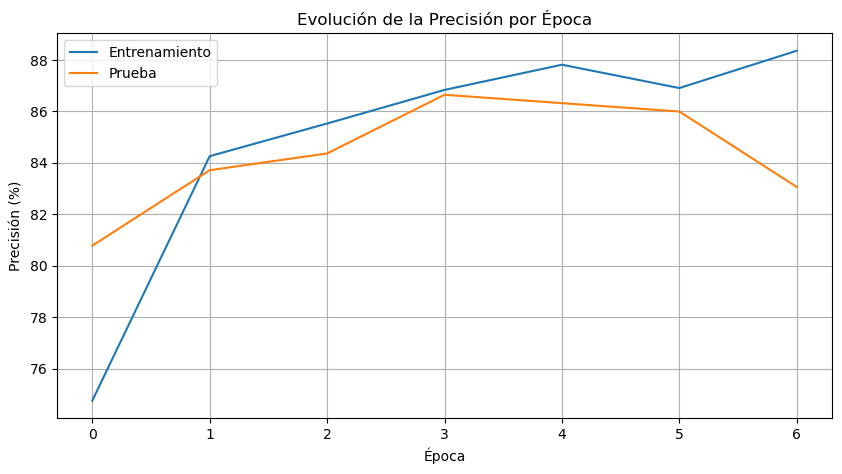

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Entrenamiento')
plt.plot(test_accuracy_values, label='Prueba')
plt.title('Evolución de la Precisión por Época')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
torch.save(model.state_dict(), 'modelo_resnet.pth')